<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [3]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [4]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

unlabeled: (26000, 1, 32, 32)
labeled data: (2000, 1, 32, 32)
labeled labels: (2000, 5)
examples from labeled, repr1, repr2, unlabeled


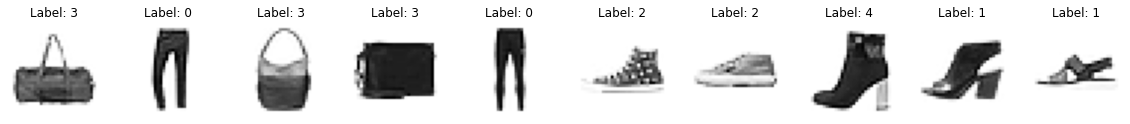

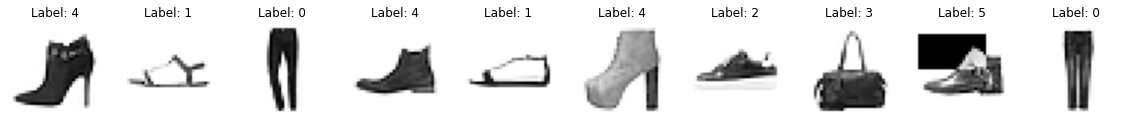

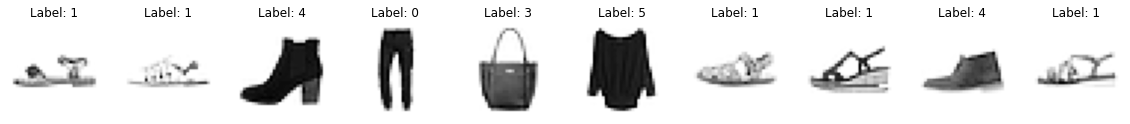

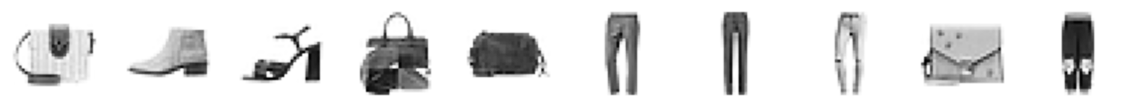

In [21]:
# code for data augmentation pipeline 
print(f'unlabeled: {full_data["unlabeled_data"].shape}')
print(f'labeled data: {full_data["labeled_data"]["data"].shape}')
print(f'labeled labels: {full_data["labeled_data"]["labels"].shape}')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

class UnlabeledDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class LabeledDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data['data'])
        self.labels = torch.tensor(data['labels'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def show_images(x, y=None, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(ncols, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        if y is not None:
            ax[idx].set_title(f'Label: {torch.nonzero(y[idx]).item()}')
    plt.show()

batch_size = 10
labeled_ds = LabeledDataset(full_data['labeled_data'])
repr_ds1 = LabeledDataset(full_data['representative_set_1'])
repr_ds2 = LabeledDataset(full_data['representative_set_2'])
unlabeled_ds = UnlabeledDataset(full_data['unlabeled_data'])

print('examples from labeled, repr1, repr2, unlabeled')
for dl in [DataLoader(ds, batch_size=batch_size, shuffle=True)
           for ds in [labeled_ds, repr_ds1, repr_ds2]]:
    for (x, y) in dl:
        show_images(x, y)
        break
for (x) in DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True):
    show_images(x)
    break

# Model definitions

In [5]:
# code for model definitions goes here
# model goals:
# 1. detect out of distribution data
# 2. give low (10) dimensional description of dataset in terms of the 5 modes
# 3. classify remaining data points into the 5 classes

# TODO ideas:
# generative model (task 1),
# embedding (task 2)
# self-supervised learning (task 3),

# similar to VAE practical 5.2

# Training and validation loop

In [6]:
# write your training and validation loop here

In [7]:
# perform training

# Inspection, Validation, and Analysis

In [8]:
# Inspect, validate, and analyse your trained model